<a href="https://colab.research.google.com/github/dcepeda2/Cumulos-abiertos/blob/main/Lab_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [68]:
from glob import glob
from astropy.io import fits
from astropy.visualization import hist
from astropy.modeling import fitting
from astropy.modeling.models import custom_model
fitter = fitting.LevMarLSQFitter()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
import scipy.ndimage as ndi
import astropy.stats as astrostats

# configuration
np.set_printoptions(linewidth=120) # para que se vea

cmap = plt.get_cmap("inferno")
cmap.set_bad(color="r")
cmap.set_over(color="w")
if "astro" in plt.colormaps():
    colormaps.unregister("astro")
colormaps.register(cmap,name="astro")
plt.rcParams["image.origin"] = "lower"
plt.rcParams["image.cmap"] = "astro"
plt.rcParams["figure.figsize"] = (10,5)
plt.rcParams["axes.labelsize"] = 15



def quantile_linspace(arr,num=100,lower=0.01,upper=0.99):
    return np.linspace(*np.quantile(np.ravel(arr),[lower,upper]),num=num)

def quantile_imshow(img,lower=0.01,upper=0.99,**kwargs):
    img_vmin = np.quantile(img,lower)
    img_vmax = np.quantile(img,upper)
    return plt.imshow(img,vmin=img_vmin,vmax=img_vmax,**kwargs)

def quantile_hist(data,num=100,lower=0.01,upper=0.99):
    return plt.hist(np.ravel(data),bins=quantile_linspace(np.ravel(data),num,lower,upper))

def pseudomode(arr,sigma=1.6,maxiters=20):
    masked = astrostats.sigma_clip(arr,sigma=sigma,maxiters=maxiters)
    return arr[~masked.mask].mean()

In [69]:
#pip install photutils

# SEXTANS A

In [70]:
hdul = fits.open("data/sextans_A.fits");
images = {hdu.name:hdu.data.astype(float) for hdu in hdul}
headers = {hdu.name:hdu.header for hdu in hdul}
hdul.close()

In [71]:
fits.info("data/sextans_A.fits")

Filename: data/sextans_A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  B             1 PrimaryHDU     179   (1701, 1501)   float32   
  1  HALPHA        1 ImageHDU       178   (1701, 1501)   float32   
  2  I             1 ImageHDU       178   (1701, 1501)   float32   
  3  OIII          1 ImageHDU       178   (1701, 1501)   float32   
  4  R             1 ImageHDU       178   (1701, 1501)   float32   
  5  SII           1 ImageHDU       178   (1701, 1501)   float32   
  6  U             1 ImageHDU       178   (1701, 1501)   float32   
  7  V             1 ImageHDU       178   (1701, 1501)   float32   


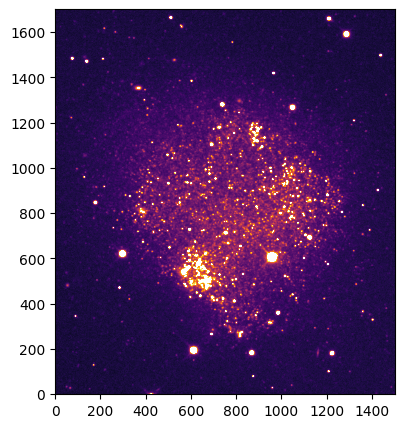

In [72]:
quantile_imshow(images["B"].T)

In [73]:
img1=images["B"]

In [74]:
img2=images["U"]

In [75]:
from skimage.feature import peak_local_max
from photutils.centroids import centroid_sources, centroid_quadratic

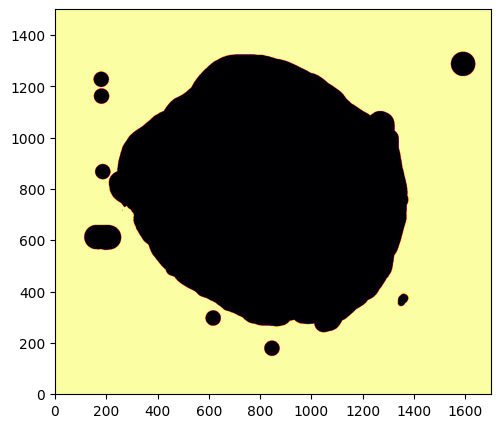

In [76]:
h = fits.open("data/sextansA_mask.fits")
imgs = {hdu.name:hdu.data.astype(float) for hdu in h}
mask = imgs['PRIMARY'].astype('int64')
plt.imshow(mask)

In [112]:
peaks1 = peak_local_max(
    ndi.gaussian_filter(img1,3),
    threshold_abs=7,
    labels=mask,
)

peaks2 = peak_local_max(
    ndi.gaussian_filter(img2,3),
    threshold_abs=9,
    labels=mask,
)

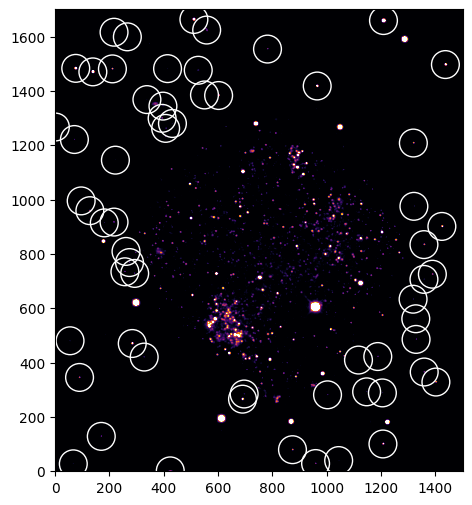

In [114]:
plt.figure(figsize=(6,6))
plt.imshow(img1.T,vmin=10,vmax=99)
plt.scatter(*peaks1.T,fc="none",ec="w",s=400)

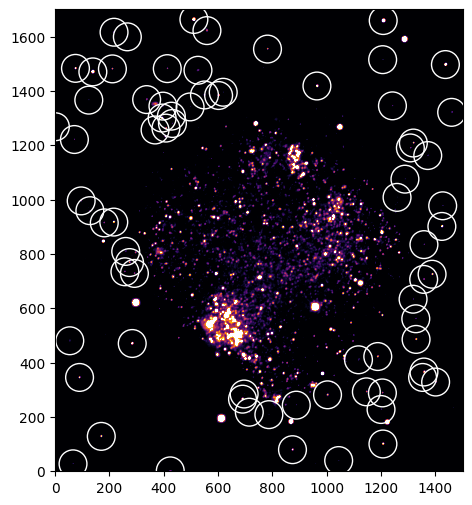

In [115]:
plt.figure(figsize=(6,6))
plt.imshow(img2.T,vmin=10,vmax=99)
plt.scatter(*peaks2.T,fc="none",ec="w",s=400)

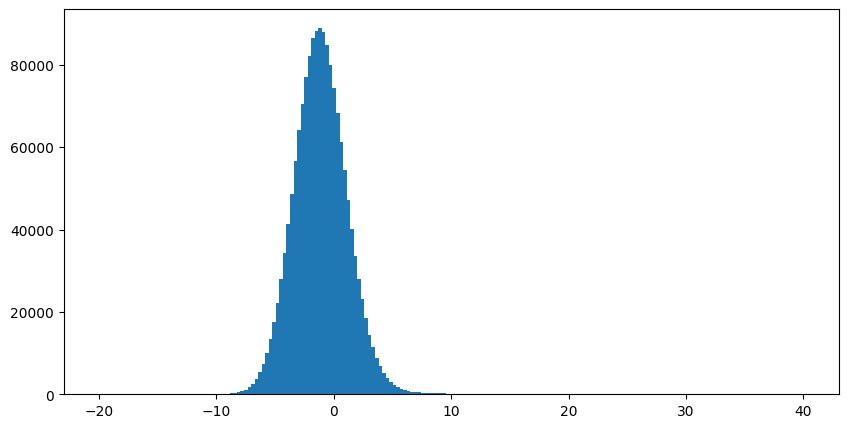

In [116]:
plt.hist(img1[mask==1].ravel(),np.linspace(-20,40,200));

In [117]:
centroids1 = np.array(
    centroid_sources((img1-img1.mean()).T,*peaks1.T,centroid_func=centroid_quadratic,box_size=9)
).T
centroids2 = np.array(
    centroid_sources((img2-img2.mean()).T,*peaks2.T,centroid_func=centroid_quadratic,box_size=9)
).T

valid_indices_centroids1 = np.where(~np.isnan(centroids1.sum(axis=1)))[0]
valid_indices_centroids2 = np.where(~np.isnan(centroids2.sum(axis=1)))[0]

centroids1_clean = centroids1[valid_indices_centroids1]
centroids2_clean = centroids2[valid_indices_centroids2]

peaks1_clean = peaks1[valid_indices_centroids1]
peaks2_clean = peaks2[valid_indices_centroids2]


In [118]:
distances1 = np.hypot(*(peaks1_clean-centroids1_clean).T)

distances2 = np.hypot(*(peaks2_clean-centroids2_clean).T)

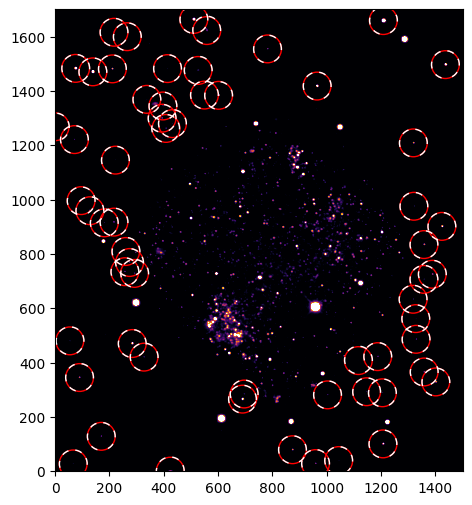

In [119]:
plt.figure(figsize=(6,6))
plt.imshow(img1.T,vmin=10,vmax=99)
plt.scatter(*centroids1_clean.T,fc="none",ec="r",s=400)
plt.scatter(*peaks1_clean.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

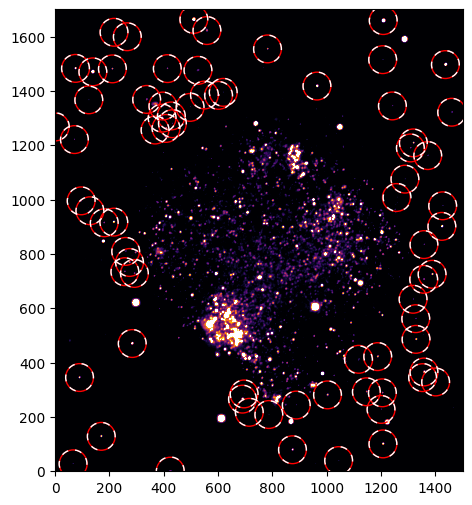

In [120]:
plt.figure(figsize=(6,6))
plt.imshow(img2.T,vmin=10,vmax=99)
plt.scatter(*centroids2_clean.T,fc="none",ec="r",s=400)
plt.scatter(*peaks2_clean.T,fc="none",ec="w",s=400,linestyle=(5,(5,5)))

# FWHM

In [121]:
from photutils.aperture import CircularAperture, ApertureStats
from photutils.profiles import RadialProfile
from astropy.modeling.models import Gaussian1D,Voigt1D,Const1D
from astropy.modeling.fitting import LevMarLSQFitter
fitter = LevMarLSQFitter(calc_uncertainties=True)

In [122]:
model = Const1D(100) + Gaussian1D(5e3,0,1.5)
model.mean_1.fixed = True

In [123]:
radii = np.arange(0,10,1)
profile1 = RadialProfile(img1.T,centroids1_clean[0],radii)
fitted_model1 = fitter(model,profile1.radius,profile1.profile)

profile2 = RadialProfile(img2.T,centroids2_clean[0],radii)
fitted_model2 = fitter(model,profile2.radius,profile2.profile)

In [124]:
params1 = []
params_std1 = []
for c in centroids1_clean:
    try:
        profile1 = RadialProfile(img1.T,c,radii)
        fitted_model1 = fitter(model,profile1.radius,profile1.profile)
        params_std1.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params1.append(fitted_model1.parameters)
    except ValueError:
        pass

params1 = np.asarray(params1)
params_std1 = np.asarray(params_std1)

params2 = []
params_std2 = []
for c in centroids2_clean:
    try:
        profile2 = RadialProfile(img2.T,c,radii)
        fitted_model2 = fitter(model,profile2.radius,profile2.profile)
        params_std2.append(np.sqrt(np.diag(fitter.fit_info["param_cov"])))
        params2.append(fitted_model2.parameters)
    except ValueError:
        pass

params2 = np.asarray(params2)
params_std2 = np.asarray(params_std2)

In [125]:
x1 = np.log10(params1.T[1])
y1 = 2*np.sqrt(2*np.log(2))*params1.T[3]
dx1 = params_std1.T[1]/params1.T[1] / np.log(10)
dy1 = 2*np.sqrt(2*np.log(2))*params_std1.T[2]

samples1 = np.random.normal(loc=y1,scale=dy1,size=(10_000,len(y1)))
means1 = samples1.mean(axis=1)

FWHM1 = means1.mean()
FWHM_err1 = means1.std()

In [126]:
x2 = np.log10(params2.T[1])
y2 = 2*np.sqrt(2*np.log(2))*params2.T[3]
dx2 = params_std2.T[1]/params2.T[1] / np.log(10)
dy2 = 2*np.sqrt(2*np.log(2))*params_std2.T[2]


samples2 = np.random.normal(loc=y2,scale=dy2,size=(10_000,len(y2)))
means2 = samples2.mean(axis=1)

FWHM2 = means2.mean()
FWHM_err2 = means2.std()

In [127]:
FWHM1

5.117433627283358

In [128]:
FWHM2

5.482428591561518

Text(0.5, 1.0, 'FWHM mean = $5.117\\pm0.025$')

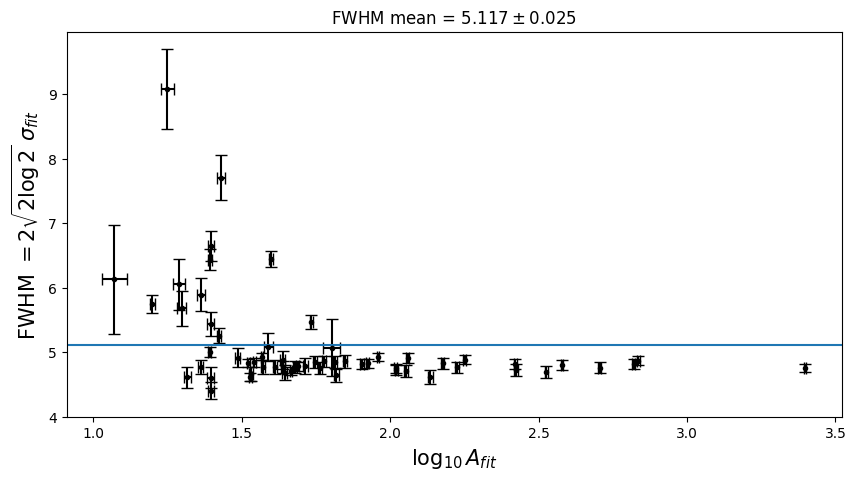

In [129]:
plt.errorbar(x1,y1,dy1,dx1,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHM1)
plt.title(f"FWHM mean = ${FWHM1:.3f}\\pm{FWHM_err1:.3f}$")

Text(0.5, 1.0, 'FWHM mean = $5.482\\pm0.017$')

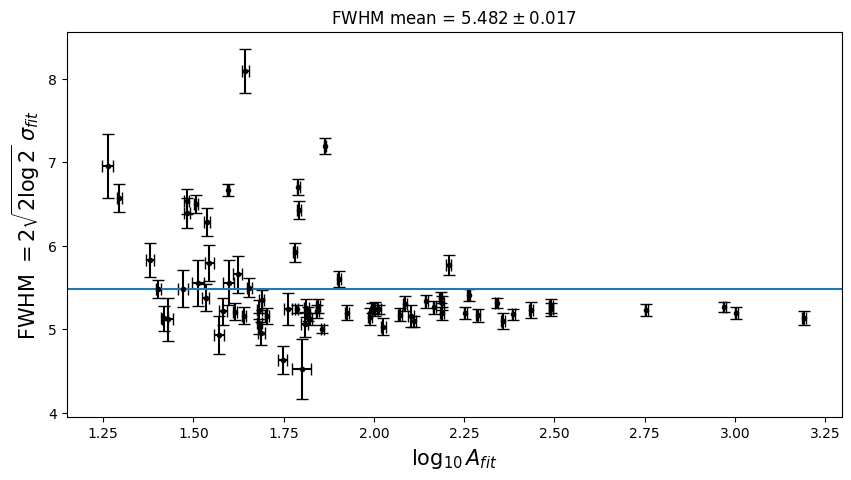

In [130]:
plt.errorbar(x2,y2,dy2,dx2,fmt=". k",capsize=4)

plt.xlabel("$\\log_{10} A_{fit}$")
plt.ylabel("FWHM $= 2\\sqrt{2\\log 2}\\;\\sigma_{fit}$")

plt.axhline(FWHM2)
plt.title(f"FWHM mean = ${FWHM2:.3f}\\pm{FWHM_err2:.3f}$")

In [133]:
from sklearn.neighbors import NearestNeighbors

In [134]:
minimum_distance1 = NearestNeighbors(n_neighbors=2).fit(centroids1_clean).kneighbors(centroids1_clean)[0][:,1].min()
minimum_distance1

19.774648073468704

In [135]:
minimum_distance2 = NearestNeighbors(n_neighbors=2).fit(centroids2_clean).kneighbors(centroids2_clean)[0][:,1].min()
minimum_distance2

20.02018098641532

In [136]:
from photutils.aperture import CircularAnnulus

In [137]:
sky_apertures1 = CircularAnnulus(centroids1_clean,0.7*(minimum_distance2-FWHM2),2*FWHM2)
star_apertures1 = CircularAperture(centroids1_clean,FWHM1)

In [138]:
sky_apertures2 = CircularAnnulus(centroids2_clean,0.7*(minimum_distance2-FWHM2),2*FWHM2)
star_apertures2 = CircularAperture(centroids2_clean,FWHM2)

In [139]:
sky_apertures1.area,star_apertures1.area

(52.36542711891345, 82.27242717346705)

In [140]:
sky_apertures2.area,star_apertures2.area

(52.36542711891345, 94.42692346732963)

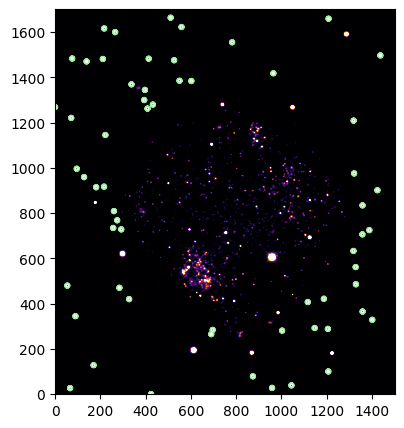

In [150]:
plt.figure(figsize=(5,5))
plt.imshow(img1.T,vmin=10,vmax=99);
sky_apertures1.plot(color="lightgreen");
star_apertures1.plot(color="w");

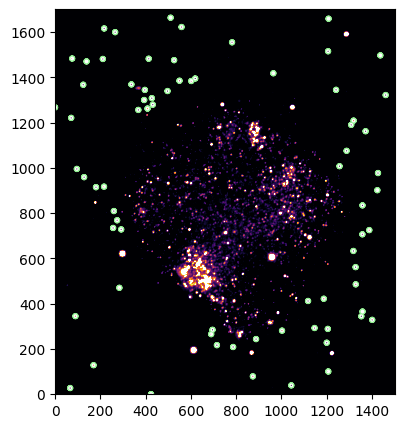

In [151]:
plt.figure(figsize=(5,5))
plt.imshow(img2.T,vmin=10,vmax=99);
sky_apertures2.plot(color="lightgreen");
star_apertures2.plot(color="w");

In [143]:
sky_values1 = ApertureStats(img1.T,sky_apertures1).median
star_values1 = ApertureStats(img1.T,star_apertures1).sum / star_apertures1.area

In [144]:
sky_values2 = ApertureStats(img2.T,sky_apertures2).median
star_values2 = ApertureStats(img2.T,star_apertures2).sum / star_apertures2.area

In [148]:
mag_ins1 = -2.5 * np.log10((star_values1 - sky_values1) / headers["B"]["EXPTIME"]) + 25 - 1.425
mag_ins1

array([20.74357161, 22.1044265 , 22.15975654, 22.46280822, 22.76682902, 22.92913968, 23.16646662, 23.15206897,
       23.57322479, 23.64872131, 23.75812624, 23.91939456, 24.0359931 , 24.09848393, 24.16946262, 24.18618014,
       24.96697805, 24.29946715, 24.40514774, 24.44827373, 24.47998758, 24.56716695, 24.66619983, 24.63177844,
       24.72324016, 24.77130579, 24.81695652, 24.79853386, 24.84166419, 24.97642276, 24.99525791, 24.99311026,
       25.57416135, 25.11574055, 25.04164889, 25.1613749 , 25.27402527, 25.3026184 , 25.08454145, 25.36024273,
       25.20992858, 25.2049153 , 25.24290465, 25.3009175 , 25.4729776 , 25.4342089 , 25.42621385, 25.51115974,
       25.38749594, 25.55391243, 25.51472415, 25.48292126, 25.86063947, 25.67430908, 26.04015154, 25.9457782 ,
       25.79980431, 25.81232759, 25.88378443, 25.77982267])

In [149]:
mag_ins2 = -2.5 * np.log10((star_values2 - sky_values2) / headers["U"]["EXPTIME"]) + 25 - 1.425
mag_ins2

array([23.72606643, 24.18142627, 24.25421888, 24.79835229, 25.4389704 , 25.44382237, 25.58083938, 25.7415797 ,
       25.84810686, 25.80610712, 25.97071086, 25.97385858, 25.99491583, 26.06464481, 26.18578555, 26.1945771 ,
       26.2253555 , 26.26195083, 26.29110879, 26.53254848, 26.39033882, 26.4035456 , 26.47737698, 26.52962071,
       26.6543968 , 26.68922664, 26.68017404, 26.72267239, 26.7263161 , 26.82508342, 26.91540067, 26.82873688,
       26.81669482, 27.5599271 , 26.98170598, 27.11554914, 27.1653326 , 26.99100398, 27.0735199 , 27.19438591,
       27.08556054, 27.18868842, 27.24703594, 27.18680892, 27.28562323, 27.42186115, 27.87685695, 27.42675829,
       27.41407539, 27.43752894, 27.42941848, 27.37462992, 27.50137717, 27.46046463, 27.53296379, 27.49616199,
       27.48757106, 27.75496763, 27.47567202, 27.6286839 , 27.64468824, 27.69794227, 27.60751045, 27.8224037 ,
       27.63723486, 27.9107985 , 28.22771242, 28.08401841, 28.01702037, 28.13170356, 27.89659536, 27.99214914,
 

In [152]:
import pandas as pd
U,B = centroids1_clean,centroids2_clean
U_mag,B_mag = mag_ins1,mag_ins2
nbrs = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(B)
distances, indices = nbrs.kneighbors(U)

indices = indices[:,0]
distances = distances[:,0]

ctrl = 0
idxs_V = np.arange(0,len(B_mag),1).tolist()
for i in range(len(B_mag)):
  if i not in indices:
    idxs_V.pop(i-ctrl)
    ctrl+=1

idxs = []
for i in indices:
  if i not in idxs:
    idxs.append(i)

df = pd.DataFrame({"U":U_mag[idxs_V],"B":B_mag[idxs],"dist":distances[idxs_V]})
df = df.query("dist<1")

IndexError: index 66 is out of bounds for axis 0 with size 60